<a href="https://colab.research.google.com/github/Jaisheesh-2006/CG_Assignment/blob/main/Polygon_filling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Polygon Fill Demo (Colab-friendly)

Choose input mode: [1] Manual coords  [2] Interactive clicks : 1
Enter polygon vertices. Examples:
 - Enter n then n lines of: x y
 - Or paste: x1,y1 x2,y2 x3,y3
Enter 'n' to specify count+coords, or paste space-separated coords: 8
Vertex 1 (x y): 60 50
Vertex 2 (x y): 300 40
Vertex 3 (x y): 340 90
Vertex 4 (x y): 260 140
Vertex 5 (x y): 280 220
Vertex 6 (x y): 180 200
Vertex 7 (x y): 120 160
Vertex 8 (x y): 80 120


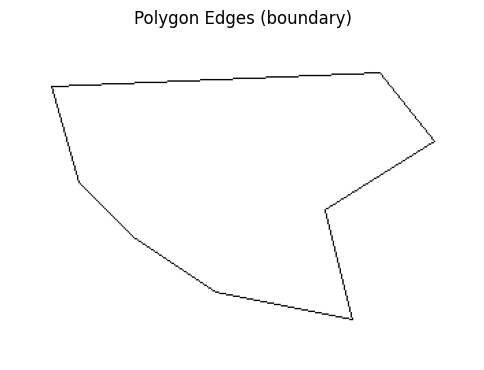

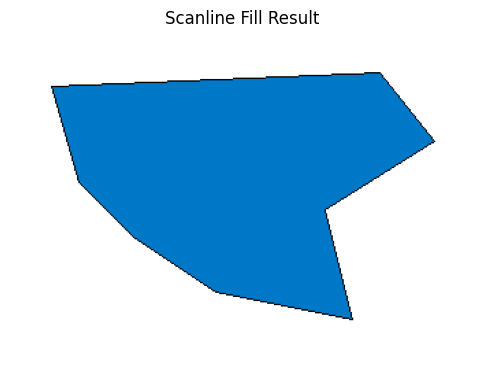

Using seed for flood/boundary fill (centroid approx): (172, 117)
Enter custom seed as 'x y' or press Enter to use centroid: 183 128


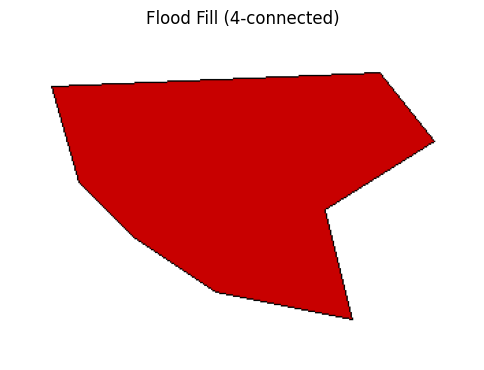

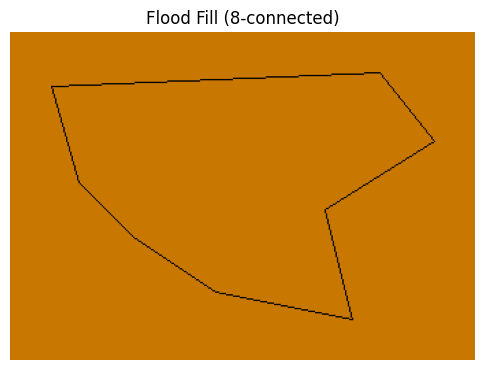

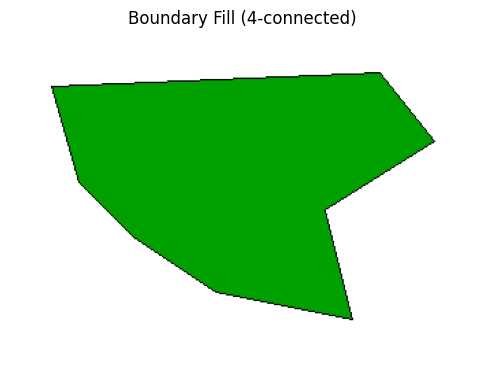

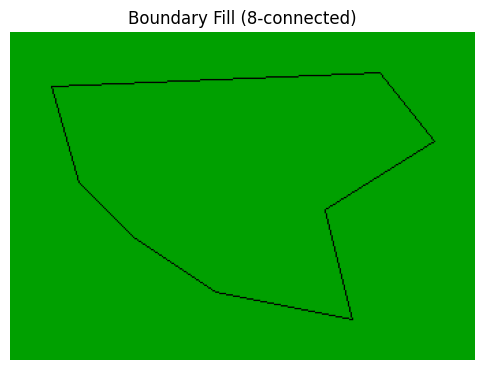

Demo complete. Replace polygon input or use interactive selection for new tests.


In [1]:
# polygon_fill_colab.py
# Run in Google Colab (or locally). Interactive point selection uses HTML/JS in Colab.

import sys
import math
import time
import json
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display

# Try to detect Colab environment
try:
    import google.colab.output as gc_output
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# --------------------------- Utilities --------------------------------

def make_canvas(width, height, bg_color=(255,255,255)):
    """Create an RGB canvas (numpy uint8). Origin (0,0) top-left."""
    return np.full((height, width, 3), bg_color, dtype=np.uint8)

def put_pixel(canvas, x, y, color):
    """Set pixel at integer (x,y) if in bounds."""
    h, w = canvas.shape[:2]
    if 0 <= x < w and 0 <= y < h:
        canvas[y, x] = color

def bresenham_line(x0, y0, x1, y1):
    """Return integer list of points from (x0,y0) to (x1,y1) using Bresenham."""
    points = []
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    x, y = x0, y0
    sx = 1 if x1 >= x0 else -1
    sy = 1 if y1 >= y0 else -1

    if dx >= dy:
        err = dx // 2
        while True:
            points.append((x, y))
            if x == x1:
                break
            x += sx
            err -= dy
            if err < 0:
                y += sy
                err += dx
    else:
        err = dy // 2
        while True:
            points.append((x, y))
            if y == y1:
                break
            y += sy
            err -= dx
            if err < 0:
                x += sx
                err += dy
    return points

def draw_polygon_edges(canvas, polygon, color=(0,0,0)):
    """Draw polygon edges on canvas. polygon: list of (x,y)."""
    n = len(polygon)
    for i in range(n):
        x0, y0 = polygon[i]
        x1, y1 = polygon[(i+1) % n]
        for (x,y) in bresenham_line(x0, y0, x1, y1):
            put_pixel(canvas, x, y, color)

# ------------------------- Scanline Fill -------------------------------

def scanline_fill(polygon, canvas, fill_color=(0,128,255), boundary_color=(0,0,0)):
    """Integer scanline fill using Active Edge List (AEL)."""
    pts = [(int(round(x)), int(round(y))) for x,y in polygon]
    ys = [p[1] for p in pts]
    if not ys:
        return
    ymin = max(min(ys), 0)
    ymax = min(max(ys), canvas.shape[0] - 1)

    edge_table = {}
    n = len(pts)
    for i in range(n):
        x0, y0 = pts[i]
        x1, y1 = pts[(i+1) % n]
        if y0 == y1:
            continue
        if y0 < y1:
            ymin_e, ymax_e = y0, y1
            x_at_ymin = x0
            dx = x1 - x0
            dy = y1 - y0
        else:
            ymin_e, ymax_e = y1, y0
            x_at_ymin = x1
            dx = x0 - x1
            dy = y0 - y1
        inv_slope = dx / dy
        edge = {'ymin': ymin_e, 'ymax': ymax_e, 'x': float(x_at_ymin), 'inv_slope': inv_slope}
        edge_table.setdefault(ymin_e, []).append(edge)

    AEL = []
    for y in range(ymin, ymax+1):
        if y in edge_table:
            AEL.extend(edge_table[y])
        AEL = [e for e in AEL if e['ymax'] > y]
        AEL.sort(key=lambda e: e['x'])
        for i in range(0, len(AEL), 2):
            if i+1 >= len(AEL):
                break
            x_start = AEL[i]['x']
            x_end = AEL[i+1]['x']
            x0 = int(math.ceil(x_start))
            x1 = int(math.floor(x_end))
            for x in range(x0, x1+1):
                put_pixel(canvas, x, y, fill_color)
        for e in AEL:
            e['x'] += e['inv_slope']

    draw_polygon_edges(canvas, pts, color=boundary_color)

# ------------------------- Flood Fill (iterative) ----------------------

def flood_fill(canvas, seed, fill_color=(255,0,0), connectivity=4, bg_tolerance=0):
    """Iterative flood fill. connectivity: 4 or 8."""
    h, w = canvas.shape[:2]
    x0, y0 = seed
    if not (0 <= x0 < w and 0 <= y0 < h):
        return
    target = tuple(int(v) for v in canvas[y0, x0])
    if tuple(fill_color) == target:
        return

    def color_match(c1, c2):
        if bg_tolerance == 0:
            return c1 == c2
        diff = sum((int(c1[i]) - int(c2[i]))**2 for i in range(3))
        return diff <= bg_tolerance**2

    stack = [(x0, y0)]
    visited = set()
    while stack:
        x, y = stack.pop()
        if (x,y) in visited:
            continue
        visited.add((x,y))
        if not (0 <= x < w and 0 <= y < h):
            continue
        current = tuple(int(v) for v in canvas[y, x])
        if not color_match(current, target):
            continue
        put_pixel(canvas, x, y, fill_color)
        if connectivity == 4:
            nbrs = [(x+1,y),(x-1,y),(x,y+1),(x,y-1)]
        else:
            nbrs = [(x+1,y),(x-1,y),(x,y+1),(x,y-1),
                    (x+1,y+1),(x-1,y-1),(x+1,y-1),(x-1,y+1)]
        for nx, ny in nbrs:
            if 0 <= nx < w and 0 <= ny < h and (nx,ny) not in visited:
                stack.append((nx,ny))

# ------------------------ Boundary Fill (iterative) --------------------

def boundary_fill(canvas, seed, fill_color=(0,255,0), boundary_color=(0,0,0), connectivity=4):
    """Iterative boundary fill. Stops at boundary_color."""
    h, w = canvas.shape[:2]
    x0, y0 = seed
    if not (0 <= x0 < w and 0 <= y0 < h):
        return
    start_color = tuple(int(v) for v in canvas[y0, x0])
    if start_color == boundary_color or start_color == tuple(fill_color):
        return

    stack = [(x0, y0)]
    visited = set()
    while stack:
        x, y = stack.pop()
        if (x,y) in visited:
            continue
        visited.add((x,y))
        if not (0 <= x < w and 0 <= y < h):
            continue
        cur = tuple(int(v) for v in canvas[y, x])
        if cur == boundary_color or cur == tuple(fill_color):
            continue
        put_pixel(canvas, x, y, fill_color)
        if connectivity == 4:
            nbrs = [(x+1,y),(x-1,y),(x,y+1),(x,y-1)]
        else:
            nbrs = [(x+1,y),(x-1,y),(x,y+1),(x,y-1),
                    (x+1,y+1),(x-1,y-1),(x+1,y-1),(x-1,y+1)]
        for nx, ny in nbrs:
            if 0 <= nx < w and 0 <= ny < h and (nx,ny) not in visited:
                stack.append((nx,ny))

# -------------------- Colab point selector (HTML/JS) -------------------

# ---- Colab HTML/JS selector with axes, grid and live coords ----
def select_points_colab(width, height, grid_step=50):
    """
    Render an HTML canvas for point selection inside Colab showing axes, grid, ticks and live coords.
    Click to add vertices, 'Done' to finish, 'Clear' to reset.
    Returns list of (x,y).
    """
    if not IS_COLAB:
        raise RuntimeError("select_points_colab should only be used in Colab.")

    unique_token = str(time.time()).replace('.', '')
    html_id = f"canvas_{unique_token}"
    span_id = f"coord_{unique_token}"
    html = f"""
    <div>
      <canvas id="{html_id}" width="{width}" height="{height}"
              style="border:1px solid #000; background:#ffffff;"></canvas><br/>
      <button id="btn_done_{html_id}">Done</button>
      <button id="btn_clear_{html_id}">Clear</button>
      <span id="{span_id}" style="margin-left:12px; font-family:monospace">x: --, y: --</span>
    </div>
    <script>
      (function(){{
        const c = document.getElementById('{html_id}');
        const ctx = c.getContext('2d');
        const W = c.width, H = c.height;
        const grid = {grid_step};

        // storage
        window.colab_points = window.colab_points || {{}};
        window.colab_done = window.colab_done || {{}};
        window.colab_points['{html_id}'] = [];
        window.colab_done['{html_id}'] = false;

        // initial drawing: grid + axes + tick labels
        function drawBackground(){{
          ctx.clearRect(0,0,W,H);
          // grid lines
          ctx.lineWidth = 1;
          ctx.strokeStyle = '#e6e6e6';
          for(let gx=0; gx<=W; gx += grid){{
            ctx.beginPath(); ctx.moveTo(gx,0); ctx.lineTo(gx,H); ctx.stroke();
          }}
          for(let gy=0; gy<=H; gy += grid){{
            ctx.beginPath(); ctx.moveTo(0,gy); ctx.lineTo(W,gy); ctx.stroke();
          }}
          // axes (top and left origin)
          ctx.strokeStyle = '#000000';
          ctx.lineWidth = 1.5;
          // x-axis (top)
          ctx.beginPath(); ctx.moveTo(0,0); ctx.lineTo(W,0); ctx.stroke();
          // y-axis (left)
          ctx.beginPath(); ctx.moveTo(0,0); ctx.lineTo(0,H); ctx.stroke();

          // ticks & labels
          ctx.fillStyle = '#000';
          ctx.font = '12px monospace';
          ctx.textAlign = 'center';
          ctx.textBaseline = 'top';
          for(let gx=0; gx<=W; gx += grid){{
            // small tick
            ctx.beginPath(); ctx.moveTo(gx, -3); ctx.lineTo(gx, 3); ctx.stroke();
            ctx.fillText(gx.toString(), gx, 4);
          }}
          ctx.textAlign = 'right';
          ctx.textBaseline = 'middle';
          for(let gy=0; gy<=H; gy += grid){{
            ctx.fillText(gy.toString(),  -6, gy);
          }}
        }}

        // redraw points
        function redrawAll(){{
          drawBackground();
          const pts = window.colab_points['{html_id}'] || [];
          ctx.fillStyle = 'red';
          ctx.strokeStyle = 'red';
          for(let i=0;i<pts.length;i++){{
            const p = pts[i];
            ctx.beginPath(); ctx.arc(p[0], p[1], 4, 0, 2*Math.PI); ctx.fill();
            // label near point
            ctx.font = '11px monospace';
            ctx.fillText('('+p[0]+','+p[1]+')', p[0]+8, p[1]-6);
          }}
          // draw polyline preview if more than 1 point
          if(pts.length>0) {{
            ctx.strokeStyle = '#0077cc';
            ctx.lineWidth = 1.5;
            ctx.beginPath();
            ctx.moveTo(pts[0][0], pts[0][1]);
            for(let i=1;i<pts.length;i++) ctx.lineTo(pts[i][0], pts[i][1]);
            ctx.stroke();
          }}
        }}

        drawBackground();

        // canvas events
        c.addEventListener('mousemove', function(e){{
          const rect = c.getBoundingClientRect();
          const x = Math.round(e.clientX - rect.left);
          const y = Math.round(e.clientY - rect.top);
          const span = document.getElementById('{span_id}');
          if(span) span.textContent = 'x: ' + x + ', y: ' + y;
        }});

        c.addEventListener('click', function(e){{
          const rect = c.getBoundingClientRect();
          const x = Math.round(e.clientX - rect.left);
          const y = Math.round(e.clientY - rect.top);
          window.colab_points['{html_id}'].push([x,y]);
          redrawAll();
        }});

        document.getElementById('btn_done_{html_id}').onclick = function() {{
          window.colab_done['{html_id}'] = true;
        }};
        document.getElementById('btn_clear_{html_id}').onclick = function() {{
          window.colab_points['{html_id}'] = [];
          window.colab_done['{html_id}'] = false;
          drawBackground();
        }};
      }})();
    </script>
    """
    display(HTML(html))

    # Poll for done
    while True:
        done = gc_output.eval_js(f"window.colab_done && window.colab_done['{html_id}'] ? true : false")
        if done:
            break
        time.sleep(0.12)

    pts_json = gc_output.eval_js(f"JSON.stringify(window.colab_points['{html_id}'] || [])")
    pts = json.loads(pts_json)
    pts = [(int(round(x)), int(round(y))) for x,y in pts]
    return pts


# ---- Local matplotlib interactive: show axes, ticks and grid ----
def input_polygon_interactive(default_canvas_size=(800,600), grid_step=50):
    """
    Collect clicks locally using matplotlib and show axes/ticks/grid to help selection.
    Returns list of (x,y) integer tuples.
    """
    if IS_COLAB:
        # Colab handled separately
        return select_points_colab(default_canvas_size[0], default_canvas_size[1], grid_step) # Call the colab specific function
    width, height = default_canvas_size
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title("Click polygon vertices; close window when done")
    ax.set_xlim(0, width)
    ax.set_ylim(height, 0)   # invert y to match image coords (top-left origin)
    ax.set_xticks(list(range(0, width+1, grid_step)))
    ax.set_yticks(list(range(0, height+1, grid_step)))
    ax.grid(True, linestyle='--', linewidth=0.6, color='gray')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    # show origin marker at top-left
    ax.plot(0, 0, marker='o', color='black', markersize=4)
    pts = plt.ginput(n=0, timeout=0)
    plt.close(fig)
    pts_int = [(int(round(x)), int(round(y))) for x,y in pts]
    return pts_int


def input_polygon_manual():
    """Prompt user to input polygon vertices (command-line style)."""
    print("Enter polygon vertices. Examples:")
    print(" - Enter n then n lines of: x y")
    print(" - Or paste: x1,y1 x2,y2 x3,y3")
    raw = input("Enter 'n' to specify count+coords, or paste space-separated coords: ").strip()
    if raw.isdigit():
        n = int(raw)
        pts = []
        for i in range(n):
            while True:
                line = input(f"Vertex {i+1} (x y): ").strip()
                try:
                    x,y = line.split()
                    pts.append((int(round(float(x))), int(round(float(y)))))
                    break
                except Exception:
                    print("Invalid. Enter two numbers separated by space.")
        return pts
    else:
        try:
            parts = raw.split()
            pts = []
            for p in parts:
                x,y = p.split(',')
                pts.append((int(round(float(x))), int(round(float(y)))))
            return pts
        except Exception:
            print("Could not parse. Try again.")
            return input_polygon_manual()

# -------------------- Visualization helpers ---------------------------

def show_image(canvas, title="Image", save_as=None):
    """Show canvas using matplotlib. Optionally save to file."""
    plt.figure(figsize=(6,6))
    plt.imshow(canvas)
    plt.title(title)
    plt.axis('off')
    if save_as:
        plt.savefig(save_as, bbox_inches='tight', dpi=150)
        print(f"Saved: {save_as}")
    plt.show()

# ----------------------------- Main -----------------------------------

def centroid_point(polygon):
    xs = [p[0] for p in polygon]
    ys = [p[1] for p in polygon]
    return (sum(xs) // len(xs), sum(ys) // len(ys))

def main():
    print("Polygon Fill Demo (Colab-friendly)\n")
    mode = input("Choose input mode: [1] Manual coords  [2] Interactive clicks : ").strip()
    if mode == '2':
        polygon = input_polygon_interactive()
        if not polygon or len(polygon) < 3:
            print("No/insufficient points captured. Exiting.")
            return
    else:
        polygon = input_polygon_manual()
        if len(polygon) < 3:
            print("Need at least 3 vertices. Exiting.")
            return

    # compute canvas size and shift polygon into padding
    xs = [p[0] for p in polygon]
    ys = [p[1] for p in polygon]
    minx, maxx = min(xs), max(xs)
    miny, maxy = min(ys), max(ys)
    pad = 30
    width = max(200, (maxx - minx) + pad*2)
    height = max(200, (maxy - miny) + pad*2)
    shift_x = pad - minx
    shift_y = pad - miny
    poly_shifted = [(x + shift_x, y + shift_y) for x,y in polygon]

    bg = (255,255,255)
    boundary_col = (0,0,0)
    scan_color = (0,120,200)
    flood4_color = (200,0,0)
    flood8_color = (200,120,0)
    boundary_fill_color = (0,160,0)

    # Draw edges only
    canvas_edges = make_canvas(width, height, bg_color=bg)
    draw_polygon_edges(canvas_edges, poly_shifted, color=boundary_col)
    show_image(canvas_edges, title="Polygon Edges (boundary)")

    # Scanline Fill
    canvas_scan = make_canvas(width, height, bg_color=bg)
    scanline_fill(poly_shifted, canvas_scan, fill_color=scan_color, boundary_color=boundary_col)
    show_image(canvas_scan, title="Scanline Fill Result")

    # Seed (centroid approx)
    seed = centroid_point(poly_shifted)
    print(f"Using seed for flood/boundary fill (centroid approx): {seed}")
    custom_seed = input("Enter custom seed as 'x y' or press Enter to use centroid: ").strip()
    if custom_seed:
        try:
            sx, sy = custom_seed.split()
            seed = (int(round(float(sx))), int(round(float(sy))))
        except Exception:
            print("Invalid seed format. Using centroid.")

    # Flood Fill (4)
    canvas_ff4 = make_canvas(width, height, bg_color=bg)
    draw_polygon_edges(canvas_ff4, poly_shifted, color=boundary_col)
    flood_fill(canvas_ff4, seed, fill_color=flood4_color, connectivity=4)
    show_image(canvas_ff4, title="Flood Fill (4-connected)")

    # Flood Fill (8)
    canvas_ff8 = make_canvas(width, height, bg_color=bg)
    draw_polygon_edges(canvas_ff8, poly_shifted, color=boundary_col)
    flood_fill(canvas_ff8, seed, fill_color=flood8_color, connectivity=8)
    show_image(canvas_ff8, title="Flood Fill (8-connected)")

    # Boundary Fill (4)
    canvas_bf4 = make_canvas(width, height, bg_color=bg)
    draw_polygon_edges(canvas_bf4, poly_shifted, color=boundary_col)
    boundary_fill(canvas_bf4, seed, fill_color=boundary_fill_color, boundary_color=boundary_col, connectivity=4)
    show_image(canvas_bf4, title="Boundary Fill (4-connected)")

    # Boundary Fill (8)
    canvas_bf8 = make_canvas(width, height, bg_color=bg)
    draw_polygon_edges(canvas_bf8, poly_shifted, color=boundary_col)
    boundary_fill(canvas_bf8, seed, fill_color=boundary_fill_color, boundary_color=boundary_col, connectivity=8)
    show_image(canvas_bf8, title="Boundary Fill (8-connected)")

    print("Demo complete. Replace polygon input or use interactive selection for new tests.")

if __name__ == "__main__":
    main()